In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from hinge_feature_extraction import * 
from cold_feature_extraction  import * 
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from threading import Thread
from multiprocessing.pool import ThreadPool


### Reading handwritten images from file and store it with it's lable 
for male y =0 and for female y =1

In [3]:
# feature extraction parameters
opt = {
        'sharpness_factor': 10,
        'bordersize': 3,
        'show_images': False,
        'is_binary': False,
    }

In [4]:
hinge_feature_vector = []
cold_feature_vector =[]
y_data =[]


cold = Cold(opt)
hinge = Hinge(opt)

In [5]:
lables = ["Males" , "Females"]

def feature_extraction(filename):
    currentDirectory = os.getcwd()

    # for each class we read it's data 
    for lable in lables:
         directory = filename+"\\"+ lable+"\\"+lable+"\\"
         path =os.path.join(currentDirectory, directory)
         class_lable = lables.index(lable)
         print(str(class_lable) + "-Start ..")
         for imagename in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, imagename)
                im = Image.open(img_path)
                hinge_f = hinge.get_hinge_features(im)
                cold_f = cold.get_cold_features(im)

                hinge_feature_vector.append(hinge_f)
                cold_feature_vector.append(cold_f)
                y_data.append(class_lable)
            except Exception as e :
                print (e)



In [83]:
def model_pipeline_testing(filename ,clf_H,clf_C):
    '''
        This function responsible for testing our models
        we have to svm models one for cold feature and one for hinge feature 
        clf_H trained model with Hinge feature 
        clf_C trained model with Cold feature 
    '''
    hinge_f_vector=[]
    cold_f_vector=[]
    currentDirectory = os.getcwd()
    directory = filename+"\\"
    path =os.path.join(currentDirectory, directory)
    for imagename in tqdm(os.listdir(path)):
            try:
                # for each image in the path 
                img_path = os.path.join(path, imagename)
                im = Image.open(img_path)
                # getting image cold and hinge feature 
                hinge_f = hinge.get_hinge_features(im)
                cold_f = cold.get_cold_features(im)
                #storing it in the feature vectors 
                hinge_f_vector.append(hinge_f)
                cold_f_vector.append(cold_f)
            except Exception as e :
                    print (e)
    # using trained model for hinge and cold 
    y_pred_hinge =clf_H.predict(hinge_f_vector)
    y_pred_cold  =clf_C.predict(cold_f_vector)
    y_pred = np.maximum(y_pred_hinge, y_pred_cold)
    return y_pred
    
    
    


In [84]:
def model_evaluation (y_test , y_predict , Lable ="Testing"):
    # testing our model using confusion matrix 
    cf = confusion_matrix(y_test, y_predict)
    cf_sum = cf.sum(axis = 1)[:, np.newaxis]
    cf = np.round(cf / cf_sum * 100, 2)
    float_formatter = "{:.2f}".format
    np.set_printoptions(formatter={'float_kind':float_formatter})    
    cr = 0.0
    for i in range(0, cf.shape[0]):
            cr += cf[i][i]

    cr /= cf.shape[0]
    print('classification rate '+Lable +' = '+ str(np.round(cr, 2)))

    print(classification_report(y_test, y_predict))
    print('Confusion Matrix ' + Lable + " Data")
    
    print(repr(cf))
    sns.heatmap(cf, annot=True,  fmt='', cmap='Blues')

In [6]:

data = feature_extraction("data_set") 


0-Start ..


  0%|                                                                                          | 0/232 [00:00<?, ?it/s]C:\Users\Yousif-Ahmed\gender-classification\cold_feature_extraction.py:115: RuntimeWarning: divide by zero encountered in log10
  rhos_log_space = np.log10(rhos)
100%|████████████████████████████████████████████████████████████████████████████████| 232/232 [14:29<00:00,  3.75s/it]


1-Start ..


100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [07:52<00:00,  3.60s/it]


### spliting the data with randomness and visualizing the data 

In [16]:
feature_vector = np.concatenate((hinge_feature_vector,cold_feature_vector) , axis=1)
np.shape(hinge_feature_vector) , np.shape(cold_feature_vector) , feature_vector.shape
hinge_max = np.shape(hinge_feature_vector)[1]


In [8]:
x_train , x_test , y_train , y_test = train_test_split(feature_vector ,y_data , test_size =0.20 , random_state =40)


(290, 1200)

## Training and Testing The Model With Hinge Feature 


In [17]:
x_hinge_train = x_train[:,:hinge_max]
x_hinge_test = x_test[:,:hinge_max]

scaler = StandardScaler()
xtrain = scaler.fit_transform(x_hinge_train)
xtest = scaler.fit_transform(x_hinge_test)

xtrain = np.nan_to_num(xtrain)
xtest = np.nan_to_num(xtest)

clf1 = SVC(kernel='rbf', verbose=True, C=10.0)
clf1.fit(xtrain, y_train)

y_pred_hinge = clf1.predict(xtrain)
y_pred_hinge_test = clf1.predict(xtest)


[LibSVM]

## Training and Testing The Model With Cold Feature

In [18]:
x_cold_train = x_train[:,hinge_max:]
x_cold_test = x_test[:,hinge_max:]

scaler = StandardScaler()

xtrain = scaler.fit_transform(x_cold_train)
xtest = scaler.fit_transform(x_cold_test)

xtrain = np.nan_to_num(xtrain)
xtest = np.nan_to_num(xtest)

clf2 = SVC(kernel='rbf', verbose=True, C=10.0)
clf2.fit(xtrain, y_train)

y_pred_cold = clf2.predict(xtrain)
y_pred_cold_test = clf2.predict(xtest)


[LibSVM]

In [19]:
y_pred = np.maximum(y_pred_hinge, y_pred_cold)
y_pred_test =np.maximum(y_pred_hinge_test, y_pred_cold_test)

## Model Evaluation

classification rate Testing = 99.47
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       188
           1       0.98      1.00      0.99       102

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290

Confusion Matrix Testing Data
array([[98.94, 1.06],
       [0.00, 100.00]])


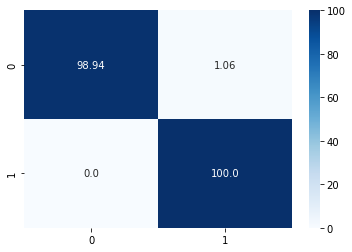

In [77]:
model_evaluation(y_train , y_pred )

classification rate Testing = 77.11
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        44
           1       0.72      0.72      0.72        29

    accuracy                           0.78        73
   macro avg       0.77      0.77      0.77        73
weighted avg       0.78      0.78      0.78        73

Confusion Matrix Testing Data
array([[81.82, 18.18],
       [27.59, 72.41]])


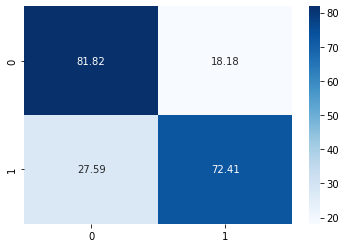

In [78]:
model_evaluation(y_test , y_pred_test , "Testing" )